# Multilayer Perceptron (MLP) for generating Onion-like News Headlines

Based on Andrej Karpathy's Youtube lecture [Building makemore Part 2: MLP](https://www.youtube.com/watch?v=TCH_1BHY58I) and Bengio et al's paper [A Neural Probabilistic Langue Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, sys, warnings, os, json, torch, re, random
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML
from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn import functional as F
import torch.nn as nn

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

In [2]:
use_gpu = lambda gpu: 'cuda' if gpu else 'cpu'
device = use_gpu(False)

In [3]:
onion_df = pd.read_csv('../data/cleaned_onion_headlines.csv')

texts = onion_df['text'].tolist()
vocab = ['#'] + sorted(list(set(' '.join(texts))))
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for i,s in enumerate(vocab)}
vocab_size = len(vocab)
vocab_size

28

## Functions

In [4]:
def build_dataset(texts, stoi, block_size=3):
  X,Y = [],[]

  for text in texts:
    context = [0] * block_size
    for ch in text:
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      context = context[1:] + [idx]

  return torch.tensor(X, device=device), torch.tensor(Y, device=device)

In [5]:
def split_datasets(X, Y, train_pct=0.8, dev_pct=0.1, device='cpu'):
  X = X.to(device)
  Y = Y.to(device)
  r = np.random.RandomState(2468975301)
  idxs = np.arange(len(X))
  r.shuffle(idxs) 

  n1 = int(train_pct*len(idxs))
  n2 = int((train_pct+dev_pct)*len(idxs))
  

  return X[idxs[:n1]],Y[idxs[:n1]],X[idxs[n1:n2]],Y[idxs[n1:n2]],X[idxs[n2:]],Y[idxs[n2:]]

## Build the Dataset

In [ ]:
block_size = 3 # contenxt length: how many characters do we take to predict the next character
X,Y = [],[]

for text in texts[:1]:
  context = [0] * block_size
  print(text)
  for ch in text + '#':
    idx = stoi[ch]
    X.append(context)
    Y.append(idx)
    print(f"{''.join(itos[i] for i in context)} -----> {itos[idx]}")
    context = context[1:] + [idx]
# X,Y = torch.tensor(X, device=device),torch.tensor(Y, device=device)
X,Y = build_dataset(texts, stoi)
X.shape, Y.shape

## Building the network

1. Let's build the table look-up `C` from the paper. In the paper, their vocab is 17K words with a 30-dim embedding. We have 28 characters, so we'll start with embedding them into 2 dimensions.
2. Lookup table is the *same* as matrix multiplication with one-hot enc.
3. Pytorch indexing with tensors with example C[X][13,2]



In [ ]:
emb_size = 2
hidden_dim = 100
input_dim = block_size * emb_size

In [ ]:
C = torch.randn((len(vocab), emb_size), device=device)
C.shape

In [ ]:
emb = C[X]
emb.shape

In [ ]:
W1 = torch.randn(input_dim, hidden_dim)
b1 = torch.randn(hidden_dim)

Best way to transform tensors `view`

In [ ]:
h = emb.view(-1, input_dim) @ W1 + b1
h.shape

In [ ]:
W2 = torch.randn((hidden_dim, len(vocab)), device=device)
b2 = torch.randn(len(vocab), device=device)

In [ ]:
logits = h @ W2 + b2
logits.shape

In [ ]:
loss = F.cross_entropy(logits, Y)
loss

In [ ]:
g = torch.Generator(device=device).manual_seed(2468975301)
X = X.to(device=device)
Y = Y.to(device=device)
C = torch.randn(vocab_size, emb_size, generator=g, requires_grad=True, device=device)
W1 = torch.randn(input_dim, hidden_dim, generator=g, requires_grad=True, device=device)
b1 = torch.randn(hidden_dim, generator=g, requires_grad=True, device=device)
W2 = torch.randn(hidden_dim, vocab_size, generator=g, requires_grad=True, device=device)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True, device=device)
params = [C, W1, b1, W2, b2]
n_params = sum([p.nelement() for p in params])
n_params

In [ ]:
batch_size = 32

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

1. So low loss because of single data point of 62 examples! 3584 params for 62 examples = overfitting single batch
2. minibatch SGD
3. Cuda
4. Learning rate determiner
5. Learning rate plateau

In [ ]:
%%time

lri = []
lossi = []

for i in range(10000):
  # minibatch SGD
  idx = torch.randint(0, len(X), (batch_size, ))
  # forward pass
  emb = C[X[idx]]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[idx])  

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()  
  
  # lr = lrs[i]
  lr = 10**-0.8
  for p in params:
    p.data += -lr * p.grad
    
  # lri.append(lre[i])
  # lossi.append(loss.item())
    
print(loss.item())    

In [ ]:
  emb = C[X]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)  
  print(f'{loss.item():0.4f}')

In [ ]:
# fig, ax = plt.subplots(1,1,figsize=(10, 8))
# ax.plot(lri, lossi)

## Dataset Splits

In [6]:
block_size = 3 # contenxt length: how many characters do we take to predict the next character
emb_size = 10
hidden_dim = 300
input_dim = block_size * emb_size
batch_size = 128
log_lossi = []
stepi = []

In [7]:
device = use_gpu(False)

In [8]:
X,Y = build_dataset(texts, stoi)
X_train,Y_train,X_dev,Y_dev,X_test,Y_test = split_datasets(X,Y, device=device)

In [9]:
g = torch.Generator(device=device).manual_seed(2468975301)
# X = X.to(device=device)
# Y = Y.to(device=device)
C = torch.randn(vocab_size, emb_size, generator=g, requires_grad=True, device=device)
W1 = torch.randn(input_dim, hidden_dim, generator=g, requires_grad=True, device=device)
b1 = torch.randn(hidden_dim, generator=g, requires_grad=True, device=device)
W2 = torch.randn(hidden_dim, vocab_size, generator=g, requires_grad=True, device=device)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True, device=device)
params = [C, W1, b1, W2, b2]
n_params = sum([p.nelement() for p in params])
print(f"Number of params: {n_params}")

Number of params: 18008


In [10]:
%%time
for i in range(200_000):
  idx = torch.randint(0, len(X_train), (batch_size, ))
  
  # forward pass
  emb = C[X_train[idx]]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train[idx])  

  # backward pass
  for p in params:
    p.grad = None
  loss.backward()  
  
  # lr = 10**-1.4
  lr = 10**-0.8 if i < 100_000 else 10**-1.4
  for p in params:
    p.data += -lr * p.grad
    
  stepi.append(i)
  log_lossi.append(loss.log10().item())

# print(f'Training Loss: {loss.item():0.4f}')

CPU times: user 15min 3s, sys: 3.17 s, total: 15min 7s
Wall time: 3min 47s


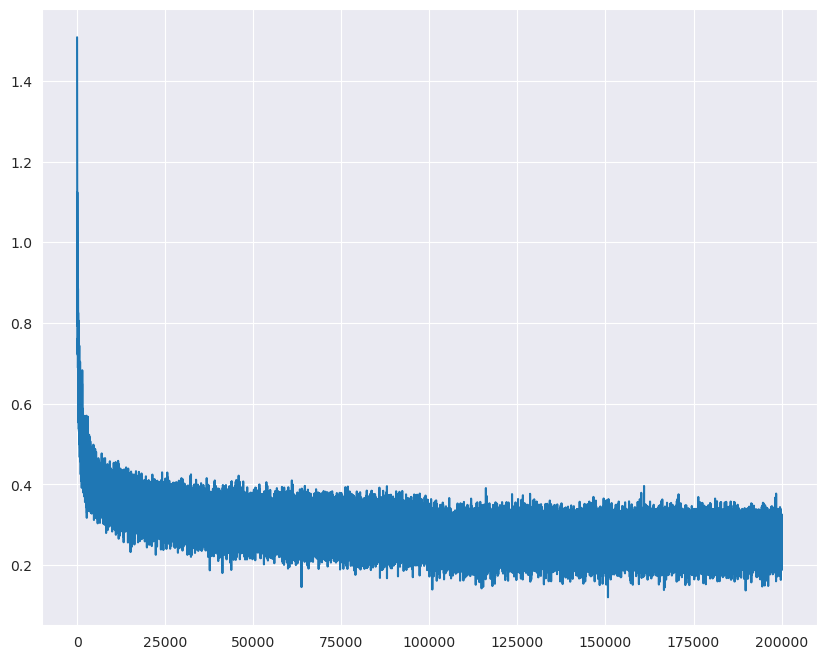

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
ax.plot(stepi, log_lossi)

In [12]:
  emb = C[X_train]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_train)  
  print(f'Training Loss: {loss.item():0.4f}')

Training Loss: 1.8240


In [13]:
  emb = C[X_dev]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_dev)  
  print(f'Dev Loss: {loss.item():0.4f}')

Dev Loss: 1.8446


In [14]:
  emb = C[X_test]
  h = torch.tanh(emb.view(-1, input_dim) @ W1 + b1) 
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_test)  
  print(f'Dev Loss: {loss.item():0.4f}')

Dev Loss: 1.8458


## Plot the embedding

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
ax.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  ax.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
  ax.grid('minor')

## Sample from the model

In [59]:
g = torch.Generator().manual_seed(2468975301)
n_headlines = 20
for _ in range(n_headlines):  
  ai_onion = []
  context = [0] * block_size # initialize with all ###
  while True:
    emb = C[torch.tensor([context])] # (1, block_size)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [idx]
    ai_onion.append(itos[idx])
    if idx == 0 or len(ai_onion) > np.random.randint(50, 100):
      break
  print(''.join(ai_onion[:-1]))

supefeer dout top divia my cand formater pkyearlycis
new heave intont aphuld womethis sand endly as played a
man chinenture loseen moverias placked aad dalept in capieade
rephe got slmonally bad yem and elds with ands look laded a glays
jurashiel caused of enockpiribrow expernored les t
study genessed and on makes beflixbers six grassagry mcro
petch monal contripple never froms to himsey silitinett
how safter hally fivanyole unveildreaking fourder at ents
kimattygonts blam movide woman juster youdgy so you had frometha
life char rakespoky flave ween more the go back no as give comp
fivestudy bor mouncoll sate appuin but userving bublic jon ding
er real live discoveric tread in froms admiting end justic 
stups jebinisish sconfirtediger fucking minalls at ticist lablic la
nework an one past mily he kintologick sunist shut s
videtlehwomathdorulment have dementy last say of veolac
his videnture convents pears logate of pups spect naw t
ordgesting connor fathiats risericreamerch leart offic